<a href="https://colab.research.google.com/github/patagypsy/Data_Analytics_Projects/blob/main/Temperature_vs_Sales_HS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The idea is to proof that weather is an indicator for higher or lower sales.

In [89]:
pip install meteostat



Get historical weather-data from meteostat (top countries)
checking for rain and temperature and getting avg. temp. by country for later anlysis


In [90]:
from google.colab import auth
auth.authenticate_user()
from pandas_gbq import read_gbq
import pandas as pd
from datetime import datetime
from meteostat import Daily, Point
import matplotlib.pyplot as plt
import seaborn as sns
import requests

top_countries = [
    {"country": "Germany",     "code": "DE", "lat": 52.5200, "lon": 13.4050},   # Berlin
    {"country": "Sweden",      "code": "SE", "lat": 59.3293, "lon": 18.0686},   # Stockholm
    {"country": "Denmark",     "code": "DK", "lat": 55.6761, "lon": 12.5683},   # Copenhagen
    {"country": "Netherlands", "code": "NL", "lat": 52.3676, "lon": 4.9041},    # Amsterdam
    {"country": "France",      "code": "FR", "lat": 48.8566, "lon": 2.3522},    # Paris
    {"country": "Austria",     "code": "AT", "lat": 48.2082, "lon": 16.3738},   # Vienna
    {"country": "Switzerland", "code": "CH", "lat": 46.9481, "lon": 7.4474},    # Bern
    {"country": "Finland",     "code": "FI", "lat": 60.1695, "lon": 24.9354},   # Helsinki
    {"country": "Poland",      "code": "PL", "lat": 52.2297, "lon": 21.0122},   # Warsaw
    {"country": "Italy",       "code": "IT", "lat": 41.9028, "lon": 12.4964},   # Rome
    {"country": "Portugal",    "code": "PT", "lat": 38.7169, "lon": -9.1399},   # Lisbon
    {"country": "Spain",       "code": "ES", "lat": 40.4168, "lon": -3.7038},   # Madrid
    {"country": "United Kingdom", "code": "UK", "lat": 51.5072, "lon": -0.1276}, # London
    {"country": "Ireland",     "code": "IE", "lat": 53.3498, "lon": -6.2603},   # Dublin
]

start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_data = []

for c in top_countries:
    location = Point(c["lat"], c["lon"])
    data = Daily(location, start, end).fetch()
    data = data.reset_index()
    data['country'] = c['country']
    data['code'] = c['code']
    weather_data.append(data[['time', 'tavg', 'prcp', 'pres', 'country', 'code']])

df_weather = pd.concat(weather_data, ignore_index=True)

print(df_weather.tail())

avg_temp_top_countries = df_weather.groupby(['country'])['tavg'].mean().sort_values().round(2)


           time  tavg  prcp    pres  country code
5119 2024-12-27   8.3   0.0  1031.2  Ireland   IE
5120 2024-12-28   8.9   0.1  1028.0  Ireland   IE
5121 2024-12-29   8.7   0.0  1027.0  Ireland   IE
5122 2024-12-30   8.9   1.2  1021.2  Ireland   IE
5123 2024-12-31   9.6  19.7  1008.2  Ireland   IE


querry order-value by country from BigQ.


In [91]:
project_id = "hatstore-fatpipe"

query = """
SELECT order_reference,created_date, total_incvat_sek,site AS country
FROM `hatstore-fatpipe.ecom.fatpipe_orders`
WHERE DATE(created_date) BETWEEN '2024-01-01' AND '2024-12-31'
AND
site IN (
    'HSDE',
    'HSDK',
    'HSNL',
    'HSSE',
    'HSFR',
    'HSAT',
    'HSCH',
    'HSFI',
    'HSPL',
    'HSIT',
    'HSPT',
    'HSES',
    'HSUK',
    'HSIE')
AND
order_status = 'Payed'
"""

df_orders = read_gbq(query, project_id=project_id)
df_orders['created_date'] = pd.to_datetime(df_orders['created_date'])

Downloading: 100%|██████████|


In [92]:
#print(df_orders.head())

In [93]:
df_orders_unique = df_orders.drop_duplicates(subset=['order_reference'])
#print(df_orders_unique.tail())

In [94]:
'''print(df_orders['created_date'].dtype)
print(df_weather['time'].dtype)
df_weather.index = pd.to_datetime(df_weather.index)'''

"print(df_orders['created_date'].dtype)\nprint(df_weather['time'].dtype)\ndf_weather.index = pd.to_datetime(df_weather.index)"

In [95]:
df_orders['country'] = df_orders['country'].str.replace(r'^HS', '', regex=True)


df = df_orders.merge(
    df_weather,
    left_on=['created_date', 'country'],
    right_on=['time', 'code']
)
#print(df.tail())


Checking Country bei where higher order-value. If rain or not? Rain is defined by > 1 mm and avg. yearly rain



In [96]:
avg_rain_top_countries = df_weather.groupby(['country'])['prcp'].mean().sort_values().round(2)
print(avg_rain_top_countries)

country
Spain             0.96
Sweden            1.23
Portugal          1.29
Germany           1.51
Poland            1.56
Finland           1.81
Ireland           1.89
Denmark           1.95
United Kingdom    1.99
France            2.21
Austria           2.26
Italy             2.42
Netherlands       3.07
Switzerland       4.04
Name: prcp, dtype: Float64


In [122]:
def label_rain(row):
    avg_rain = avg_rain_top_countries.get(row['country_y'], None)
    # Prüfe, ob avg_rain, tavg oder prcp fehlen, sonst None zurückgeben
    if avg_rain is None or pd.isna(row['tavg']) or pd.isna(row['prcp']):
        return None
    return 'rainy' if row['prcp'] > avg_rain else 'not rainy'

df['rain_label'] = df.apply(label_rain, axis=1)

avg_order_rain = df.groupby(['country_y', 'rain_label'])['total_incvat_sek'].mean().unstack().round(2)

avg_order_rain['result'] = avg_order_rain.apply(
    lambda row: 'Higher on rainy days' if row.get('rainy', 0) > row.get('not rainy', 0) else 'Higher on less rainy days',
    axis=1
)

avg_order_rain['avg_rain'] = avg_order_rain.index.map(avg_rain_top_countries)
avg_order_rain = avg_order_rain.sort_values(by=['result', 'avg_rain'])

print(avg_order_rain)


rain_label      not rainy    rainy                     result  avg_rain
country_y                                                              
Spain              873.62   767.42  Higher on less rainy days      0.96
Germany            844.45   843.27  Higher on less rainy days      1.51
Poland             765.63   757.35  Higher on less rainy days      1.56
Denmark            783.64   777.20  Higher on less rainy days      1.95
France             752.66   730.40  Higher on less rainy days      2.21
Austria           1010.24  1005.91  Higher on less rainy days      2.26
Italy              798.06   777.52  Higher on less rainy days      2.42
Sweden             668.93   681.24       Higher on rainy days      1.23
Portugal           844.86   846.50       Higher on rainy days      1.29
Finland            829.91   831.49       Higher on rainy days      1.81
Ireland            713.43   745.17       Higher on rainy days      1.89
United Kingdom     785.20   812.61       Higher on rainy days   

In [115]:
'''df['rainy'] = df['prcp']> 1
avg_df_prcp = df.groupby(['country_y', 'rainy'])['total_incvat_sek'].mean().unstack()'''


"df['rainy'] = df['prcp']> 1\navg_df_prcp = df.groupby(['country_y', 'rainy'])['total_incvat_sek'].mean().unstack()"



Order Value by AVG temp. of every single country (Higher when warm or cold)


In [120]:
def label_temp(row):
    avg_temp = avg_temp_top_countries.get(row['country_y'], None)
    if avg_temp is None or pd.isna(row['tavg']):
        return None
    return 'warm' if row['tavg'] > avg_temp else 'cold'

df['temp_label'] = df.apply(label_temp, axis=1)
avg_order_temp = df.groupby(['country_y', 'temp_label'])['total_incvat_sek'].mean().unstack().round(2)

avg_order_temp['result'] = avg_order_temp.apply(
    lambda row: 'Higher on warm days' if row.get('warm', 0) > row.get('cold', 0) else 'Higher on cold days',
    axis=1
)

avg_order_temp['avg_temp'] = avg_order_temp.index.map(avg_temp_top_countries)
avg_order_temp = avg_order_temp.sort_values(by=['result', 'avg_temp'])

print(avg_order_temp)

temp_label         cold     warm               result  avg_temp
country_y                                                      
Sweden           675.33   664.86  Higher on cold days      8.37
Ireland          734.43   711.85  Higher on cold days     10.42
Switzerland     1467.62  1385.10  Higher on cold days     10.57
United Kingdom   798.30   787.14  Higher on cold days     11.38
Poland           773.50   756.88  Higher on cold days     11.67
Netherlands      712.27   699.16  Higher on cold days     11.97
Germany          884.07   805.01  Higher on cold days     12.31
France           753.36   741.77  Higher on cold days      13.2
Austria         1071.51   949.74  Higher on cold days      14.2
Finland          821.92   836.82  Higher on warm days      7.92
Denmark          767.93   788.24  Higher on warm days     10.35
Spain            829.93   903.23  Higher on warm days     15.66
Italy            793.13   793.41  Higher on warm days      17.3
Portugal         828.68   859.52  Higher



Same but just by defintion of over and under 15 degree



In [105]:
avg_order_15 = avg_order_temp.sort_values('avg_temp').reset_index()

print(avg_order_15)

temp_label       country_y     cold     warm               result  avg_temp
0                  Finland   821.92   836.82  Higher on warm days      7.92
1                   Sweden   675.33   664.86  Higher on cold days      8.37
2                  Denmark   767.93   788.24  Higher on warm days     10.35
3                  Ireland   734.43   711.85  Higher on cold days     10.42
4              Switzerland  1467.62  1385.10  Higher on cold days     10.57
5           United Kingdom   798.30   787.14  Higher on cold days     11.38
6                   Poland   773.50   756.88  Higher on cold days     11.67
7              Netherlands   712.27   699.16  Higher on cold days     11.97
8                  Germany   884.07   805.01  Higher on cold days     12.31
9                   France   753.36   741.77  Higher on cold days      13.2
10                 Austria  1071.51   949.74  Higher on cold days      14.2
11                   Spain   829.93   903.23  Higher on warm days     15.66
12          

Recommandation by Country


In [127]:
merged_df = avg_order_temp.merge(avg_order_rain, on='country_y', how='left')

#print(merged_df[['result_x', 'avg_temp', 'result_y', 'avg_rain']])

merged_df = merged_df.rename(columns={
    'result_x': 'temp',
    'result_y': 'rain'})
print(merged_df[['avg_temp', 'temp',  'avg_rain','rain']])


                avg_temp                 temp  avg_rain  \
country_y                                                 
Sweden              8.37  Higher on cold days      1.23   
Ireland            10.42  Higher on cold days      1.89   
Switzerland        10.57  Higher on cold days      4.04   
United Kingdom     11.38  Higher on cold days      1.99   
Poland             11.67  Higher on cold days      1.56   
Netherlands        11.97  Higher on cold days      3.07   
Germany            12.31  Higher on cold days      1.51   
France              13.2  Higher on cold days      2.21   
Austria             14.2  Higher on cold days      2.26   
Finland             7.92  Higher on warm days      1.81   
Denmark            10.35  Higher on warm days      1.95   
Spain              15.66  Higher on warm days      0.96   
Italy               17.3  Higher on warm days      2.42   
Portugal            17.8  Higher on warm days      1.29   

                                     rain  
country_y  

In [129]:
for idx, row in merged_df.iterrows():
    country = idx
    temp_label = row['temp']
    avg_temp = row['avg_temp']
    rain_label = row['rain']
    avg_rain = row['avg_rain']

    if temp_label == 'Higher on cold days':
        temp_text = 'If Temp is below'
    else:
        temp_text = 'If Temp is above'

    if rain_label == 'Higher on less rainy days':
        rain_text = 'and less rain then'
    else:
        rain_text = 'and more rain then'

    print(f"{country}: {temp_text} {avg_temp} C {rain_text} {avg_rain} mm, chances a higher for more revenue! \n" )



Sweden: If Temp is below 8.37 C and more rain then 1.23 mm, chances a higher for more revenue! 

Ireland: If Temp is below 10.42 C and more rain then 1.89 mm, chances a higher for more revenue! 

Switzerland: If Temp is below 10.57 C and more rain then 4.04 mm, chances a higher for more revenue! 

United Kingdom: If Temp is below 11.38 C and more rain then 1.99 mm, chances a higher for more revenue! 

Poland: If Temp is below 11.67 C and less rain then 1.56 mm, chances a higher for more revenue! 

Netherlands: If Temp is below 11.97 C and more rain then 3.07 mm, chances a higher for more revenue! 

Germany: If Temp is below 12.31 C and less rain then 1.51 mm, chances a higher for more revenue! 

France: If Temp is below 13.2 C and less rain then 2.21 mm, chances a higher for more revenue! 

Austria: If Temp is below 14.2 C and less rain then 2.26 mm, chances a higher for more revenue! 

Finland: If Temp is above 7.92 C and more rain then 1.81 mm, chances a higher for more revenue! 

De

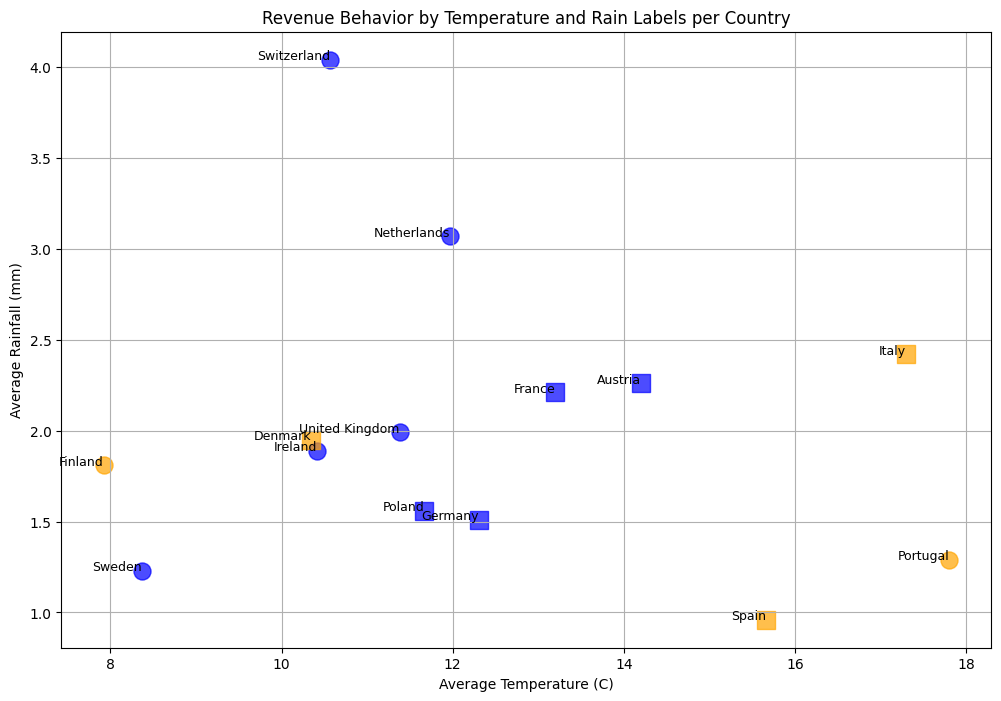

In [130]:

plt.figure(figsize=(12,8))

palette_temp = {'Higher on warm days':'orange', 'Higher on cold days':'blue'}
markers_rain = {'Higher on rainy days':'o', 'Higher on less rainy days':'s'}

for idx, row in merged_df.iterrows():
    plt.scatter(row['avg_temp'], row['avg_rain'],
                color=palette_temp.get(row['temp'], 'gray'),
                marker=markers_rain.get(row['rain'], 'o'),
                s=150, alpha=0.7)
    plt.text(row['avg_temp'], row['avg_rain'], idx, fontsize=9, ha='right')

plt.xlabel('Average Temperature (C)')
plt.ylabel('Average Rainfall (mm)')
plt.title('Revenue Behavior by Temperature and Rain Labels per Country')
plt.grid(True)
plt.show()